# Importing necessary packages

In [ ]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sympy as sym
# from google.colab import drive
# drive.mount('/content/drive')


In [ ]:
%cd /content/drive/MyDrive/New_Dataset-Day2/New_Dataset-Day2/

[Errno 2] No such file or directory: '/content/drive/MyDrive/New_Dataset-Day2/New_Dataset-Day2/'
/content


In [ ]:
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials as creds

import gspread as gs
from google.auth import default
creds, _ = default()

gc = gs.authorize(creds)

# Helper functions

In [ ]:
def df_from_sheet(link):
  gc = gs.authorize(creds)

  wb = gc.open_by_url(link)

  sheet = wb.sheet1
  data = sheet.get_all_values()

  df = pd.DataFrame(data)
  df.columns = df.iloc[0]
  df = df.iloc[1:]

  df = df.astype(np.float)

  #df = df.rename(columns={'Time (s)':'Time', '|V|':'V'})

  return df

def TransformData(amat):
  trans_amat = []

  for vec in amat.T:
    ax = vec[0]
    ay = vec[1]
    az = vec[2]

    alpha = np.arctan(ay/az)

    beta = np.arctan((-ax)/np.sqrt(ay**2 + az**2))

    r1 = [[1, 0, 0],
          [0, np.cos(alpha), -np.sin(alpha)],
          [0, np.sin(alpha), np.cos(alpha)]]

    r2 = [[np.cos(beta), 0, np.sin(beta)],
          [0, 1, 0],
          [-np.sin(beta), 0, np.cos(beta)]]

    r1 = np.array(r1)
    r2 = np.array(r2)

    t_vec = r2 @ r1 @ vec.T

    ax1 = t_vec[0]
    ay1 = t_vec[1]

    gamma = np.arctan(ax/ay)

    r3 = np.array([[np.cos(gamma), -np.sin(gamma), 0],
                  [np.sin(gamma), np.cos(gamma), 0], 
                  [0, 0, 1]])
    
    final_vec = r3 @ t_vec

    trans_amat.append(final_vec)

  trans_amat = np.array(trans_amat)
  transformed = trans_amat.T
  new_df = pd.DataFrame(data=transformed.T, columns=['X', 'Y', 'Z'])
  return new_df

def Analysis_pipeline(df:pd.DataFrame, column:str, ma=True):
  min = df[column].min()
  max = df[column].max()
  std = df[column].std()
  mean = df[column].mean()
  print(f'\n -------------- {column} ---------------------')
  
  
 
  plt.figure(figsize=(12,8))
  
  if ma:
    plt.plot(df['EMA'+column.lower()])
    plt.title(f'EMA{column.lower()}')
  else:
    plt.title(f'{column}')
  #plt.figure(figsize=(12,8))
  plt.plot(df[column])
  plt.axhline((mean), ls='-.', color='red', linewidth=3.5, label='mean')
  plt.legend()
  
  plt.figure(figsize=(12,8))
  plt.plot(df[column])
  plt.plot((min/2)*np.ones(df[column].shape))
  plt.plot((max/2)*np.ones(df[column].shape))
  plt.title('Bounded by hard parameters')
  
  plt.figure(figsize=(10,6))
  sns.kdeplot(df[column], shade=True, legend=True)
  plt.axvline(x=mean, label='mean')
  plt.axvline(x=(mean+2*std), ls=':', label='stdev')
  plt.axvline(x=(mean-2*std), ls=':')
  plt.legend(fontsize='x-large')

  x = np.arange(0,df[column].shape[0],1)

  plt.figure(figsize=(16,8))
  plt.plot(df[column])
  plt.axhline((mean+2*std), ls=':', color='coral', linewidth=3.5)
  plt.axhline((mean-2*std), ls=':', color='coral', linewidth=3.5, label='strategic')
  plt.plot((min/2)*np.ones(df[column].shape), linewidth=0.5, label='hardcoded')
  plt.plot((max/2)*np.ones(df[column].shape), linewidth=0.5)
  plt.fill_between(x, (mean+std)*np.ones(df[column].shape), (max/2)*np.ones(df[column].shape), color='gray', alpha=0.2, label='lost_info')
  plt.fill_between(x, (mean-std)*np.ones(df[column].shape), (min/2)*np.ones(df[column].shape), color='gray', alpha=0.2)
  plt.title('Bounded by Distribution Parameters')
  plt.legend(fontsize='x-large')
  plt.show()

  print(f'\n -------------- END ---------------------')

def ema (df:pd.DataFrame, column:str, length:int):
  #length = df.size/4
  length /= 200
  smoothing =5
  multiplier = smoothing/(length+1)

  x= df[column].to_numpy()
  
  result = np.array([x[0]])
  #print(result)
  for i in range(1,len(x)):
    #new_arr = np.concatenate( (arr, [10] ) )
    result = np.concatenate((result,[round(x[i]*multiplier + (1-multiplier)*x[i-1],3)]))
  #print(result)
  return np.array(result)






In [ ]:
df = df_from_sheet('https://docs.google.com/spreadsheets/d/1DAWIHs-O88mdQTh1owsJs_IOid-igrxDyEP6KikiJOI/edit?usp=sharing')
#df = pd.read_csv("/content/drive/MyDrive/New_Dataset-Day2/New_Dataset-Day2/Accelerometer.csv")
df.columns=['Time','X','Y','Z']
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]


,Time,X,Y,Z
1,1.643633e+12,-1.285553,6.907990,6.896622
2,1.643633e+12,-1.347809,6.836151,6.894226
3,1.643633e+12,-1.426804,6.848129,6.865494
4,1.643633e+12,-1.481873,6.924744,6.889435
5,1.643633e+12,-1.527374,7.049240,6.889435


In [ ]:
df.shape

(14042, 4)

In [ ]:
#df.drop(['Label'], axis = 1,inplace=True)
#df = df.rename(columns={'seconds_elapsed':'Time','time':'Date'})
#df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')
df.head()


,Time,X,Y,Z
1,1.643633e+12,-1.285553,6.907990,6.896622
2,1.643633e+12,-1.347809,6.836151,6.894226
3,1.643633e+12,-1.426804,6.848129,6.865494
4,1.643633e+12,-1.481873,6.924744,6.889435
5,1.643633e+12,-1.527374,7.049240,6.889435


In [ ]:
i = 4
for cols in ['X', 'Y', 'Z' ]:
  x = ema(df,cols,df.size/i)
  print(x)
  df['EMA'+cols.lower()]=pd.Series(x)
  i+=1

df = df.astype(np.float)
df.dtypes


[3.63751953e-01 3.64000000e-01 3.74000000e-01 ... 7.50555000e+02
 7.50565000e+02 7.50575000e+02]
[-3.19735241 -3.201      -3.547      ...  0.212       0.036
 -0.045     ]
[0.56459856 0.573      1.285      ... 0.438      0.491      0.495     ]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


Time     float64
X        float64
Y        float64
Z        float64
Label    float64
EMAx     float64
EMAy     float64
EMAz     float64
dtype: object

In [ ]:
df['EMAx'] = df['X'].ewm(span=10, adjust=False).mean()
df['EMAy'] = df['Y'].ewm(span=10, adjust=False).mean()
df['EMAz'] = df['Z'].ewm(span=10, adjust=False).mean()
df.head()

,Time,X,Y,Z,EMAx,EMAy,EMAz
1,1.643633e+12,-1.285553,6.907990,6.896622,-1.285553,6.907990,6.896622
2,1.643633e+12,-1.347809,6.836151,6.894226,-1.296872,6.894928,6.896186
3,1.643633e+12,-1.426804,6.848129,6.865494,-1.320496,6.886419,6.890606
4,1.643633e+12,-1.481873,6.924744,6.889435,-1.349837,6.893387,6.890393
5,1.643633e+12,-1.527374,7.049240,6.889435,-1.382117,6.921724,6.890219


In [ ]:
df.describe()

,Time,X,Y,Z,EMAx,EMAy,EMAz
count,7.467400e+04,74674.000000,74674.000000,74674.000000,74674.000000,74674.000000,74674.000000
mean,1.645598e+18,375.468210,-0.022877,-0.043119,375.423003,-0.023077,-0.043108
std,3.334477e+11,216.574060,1.154639,0.911824,216.574053,0.915396,0.681419
min,1.645598e+18,0.363752,-12.083581,-7.198878,0.363752,-5.097476,-5.101003
25%,1.645598e+18,187.912959,-0.452148,-0.435076,187.867747,-0.289953,-0.305538
50%,1.645598e+18,375.465704,0.000001,-0.021948,375.420462,-0.008589,-0.026394
75%,1.645599e+18,563.020947,0.436882,0.351639,562.975728,0.267810,0.227136
max,1.645600e+18,750.584952,6.391089,6.891160,750.539800,4.613276,4.789509


In [ ]:
df.head()

,Time,X,Y,Z,EMAx,EMAy,EMAz
1,1.645598e+18,0.363752,-3.197352,0.564599,0.363752,-3.197352,0.564599
2,1.645600e+18,0.373610,-3.543774,1.284158,0.365544,-3.260338,0.695428
3,1.645598e+18,0.383504,-3.820687,1.342828,0.368810,-3.362220,0.813137
4,1.645598e+18,0.393438,-3.688761,0.874257,0.373288,-3.421591,0.824249
5,1.645598e+18,0.403415,-3.485143,0.752547,0.378765,-3.433146,0.811213


In [ ]:
#df['Time'] = pd.to_datetime(df['Time'], format='%Y%m%d%H%M%S')
#df['Date'] = pd.to_timedelta(df['Date'], unit='D')
df['Time'] = pd.to_datetime(df['Time']).dt.strftime('%H:%M:%S')

#df['Time'] = df['Time'].astype(str).str.extract('days (.*?)\.')
#df["Date"] = pd.to_datetime(df.Date).dt.strftime('%H:%M:%S')
#df=df[df['Date'].isin(pd.date_range(start='06:33', end='06:46'))]



#df['Time'] = df['Time'] - pd.to_timedelta(df['Time'].dt.days, unit='D')
df.head()

,Time,X,Y,Z,EMAx,EMAy,EMAz
1,06:33:09,0.363752,-3.197352,0.564599,0.363752,-3.197352,0.564599
2,07:06:40,0.373610,-3.543774,1.284158,0.365544,-3.260338,0.695428
3,06:33:09,0.383504,-3.820687,1.342828,0.368810,-3.362220,0.813137
4,06:33:09,0.393438,-3.688761,0.874257,0.373288,-3.421591,0.824249
5,06:33:09,0.403415,-3.485143,0.752547,0.378765,-3.433146,0.811213


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74674 entries, 1 to 74674
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    74674 non-null  object 
 1   X       74674 non-null  float64
 2   Y       74674 non-null  float64
 3   Z       74674 non-null  float64
 4   EMAx    74674 non-null  float64
 5   EMAy    74674 non-null  float64
 6   EMAz    74674 non-null  float64
dtypes: float64(6), object(1)
memory usage: 4.0+ MB


# Visualization

In [ ]:
df.dtypes

Time      object
X        float64
Y        float64
Z        float64
Label    float64
EMAx     float64
EMAy     float64
EMAz     float64
dtype: object


 -------------- X ---------------------


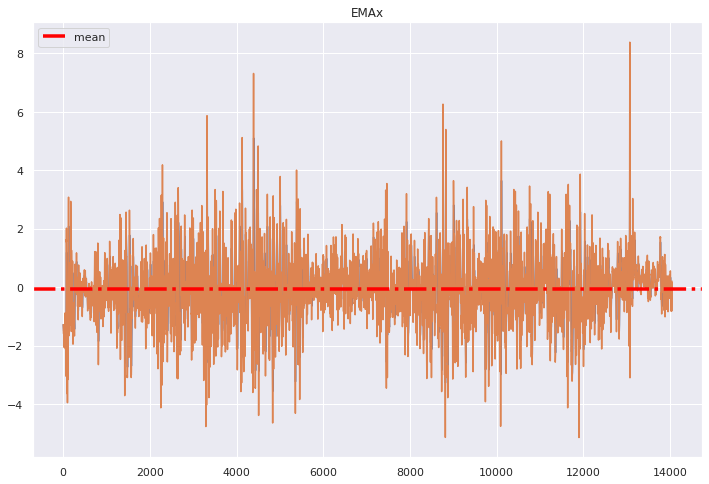

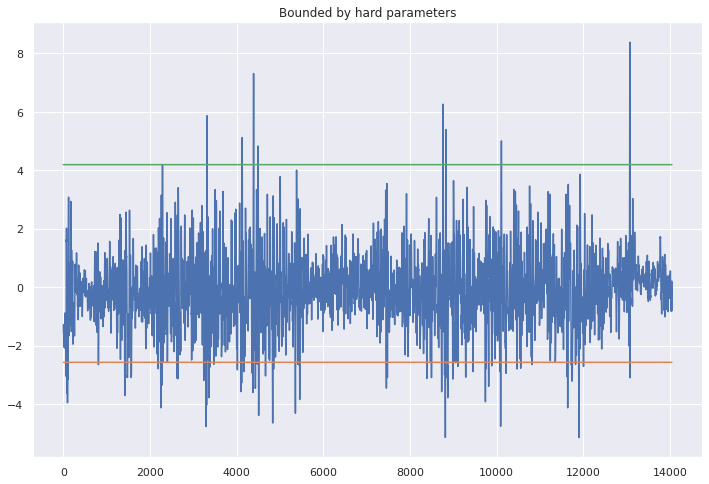

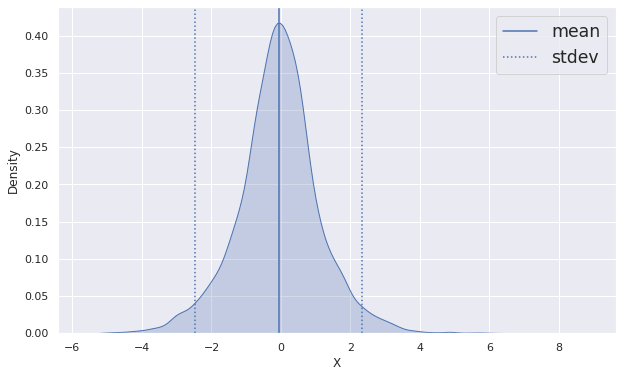

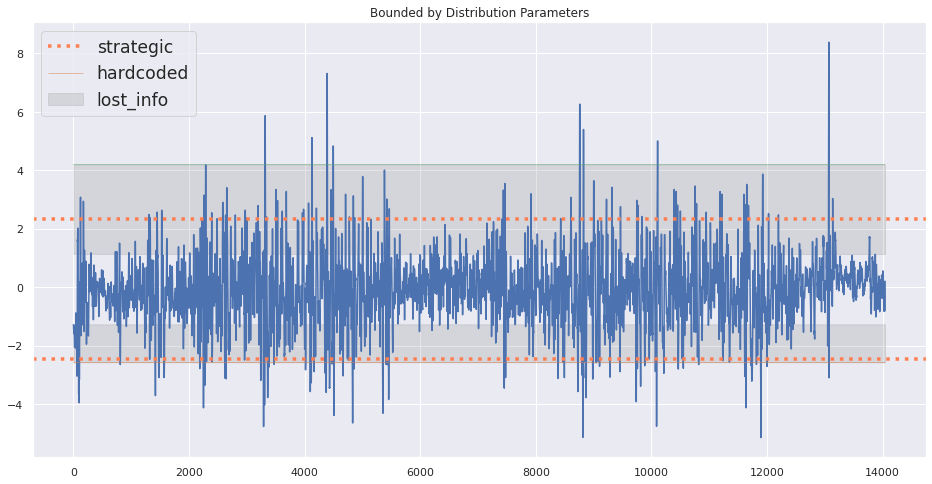


 -------------- END ---------------------

 -------------- Y ---------------------


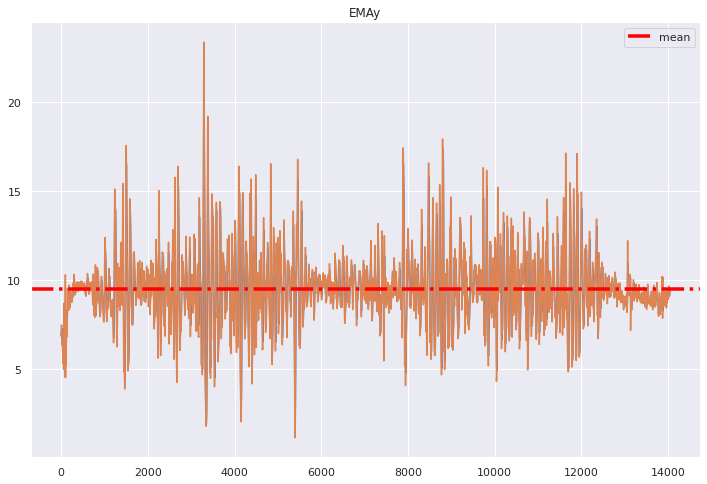

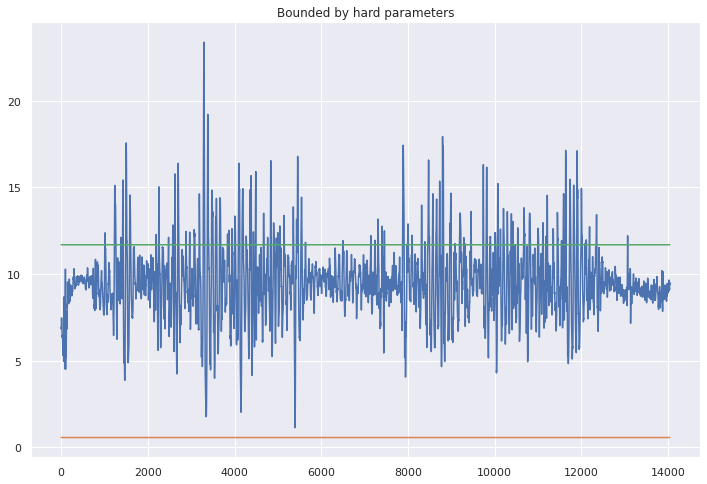

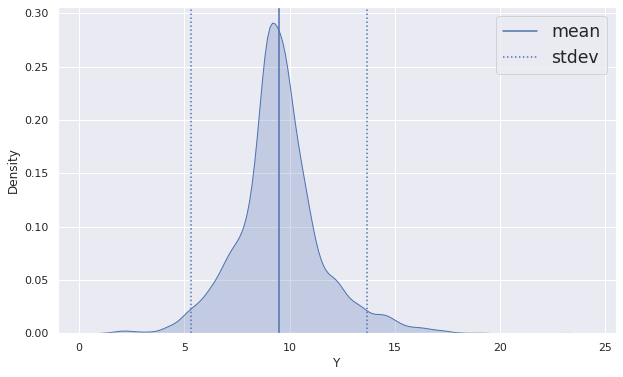

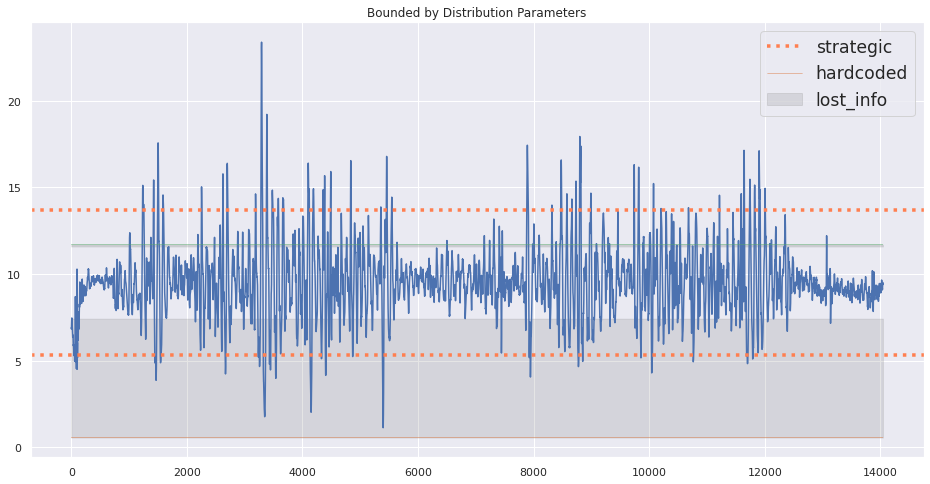


 -------------- END ---------------------

 -------------- Z ---------------------


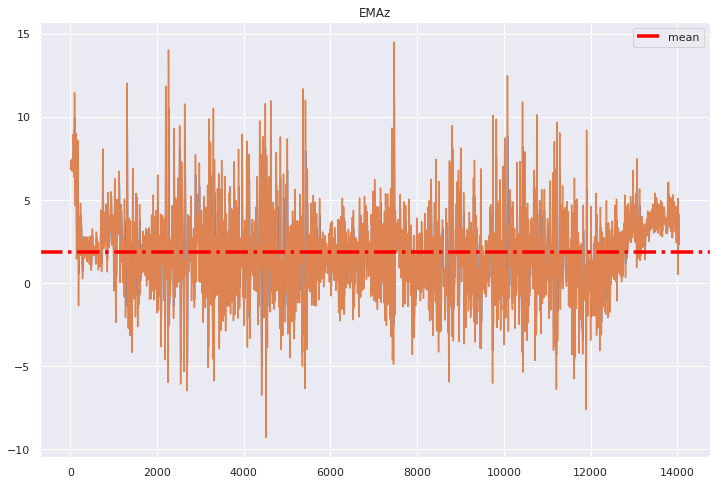

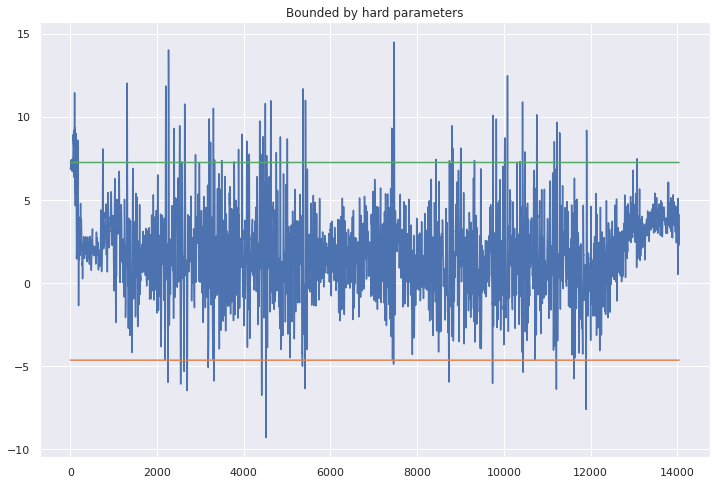

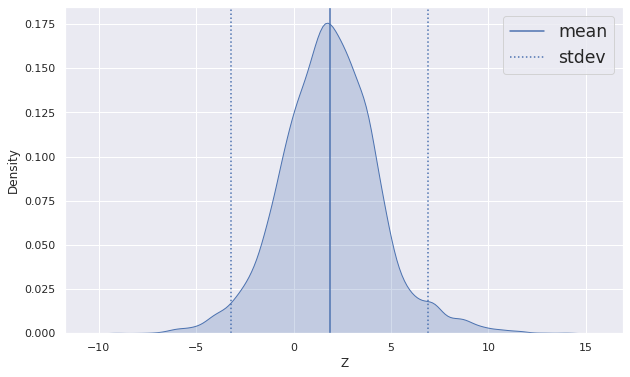

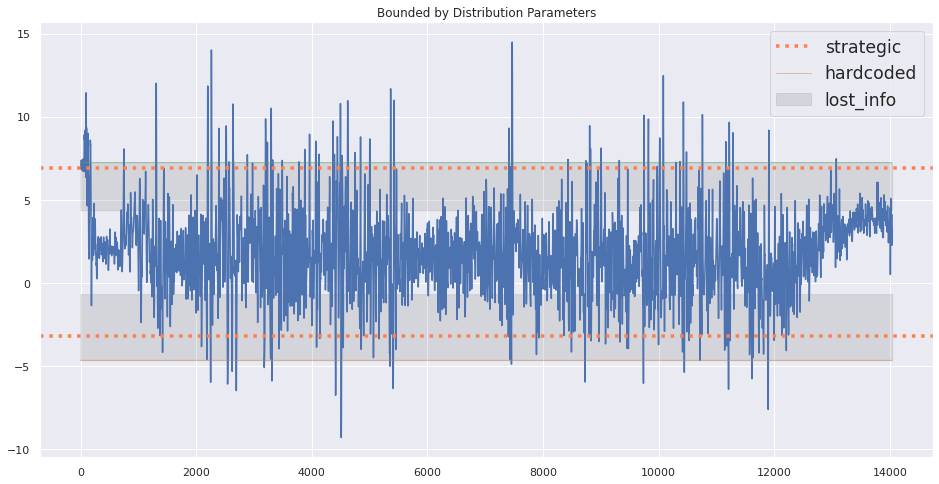


 -------------- END ---------------------


In [ ]:
for cols in ['X', 'Y', 'Z']:
  Analysis_pipeline(df, cols)

          Time         X         Y         Z      EMAx      EMAy      EMAz
Time  1.000000  0.075045  0.015597 -0.033966  0.099561  0.017942 -0.044003
X     0.075045  1.000000 -0.229551  0.303671  0.810414 -0.026084  0.167518
Y     0.015597 -0.229551  1.000000 -0.066278 -0.425558  0.927019 -0.169672
Z    -0.033966  0.303671 -0.066278  1.000000  0.225242  0.103517  0.843780
EMAx  0.099561  0.810414 -0.425558  0.225242  1.000000 -0.242611  0.225084
EMAy  0.017942 -0.026084  0.927019  0.103517 -0.242611  1.000000 -0.023201
EMAz -0.044003  0.167518 -0.169672  0.843780  0.225084 -0.023201  1.000000


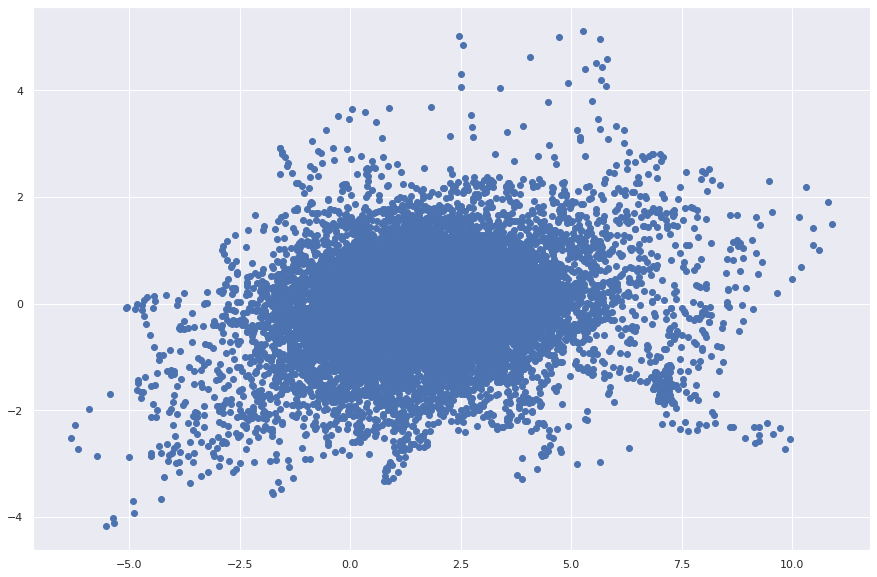

In [ ]:
print(df.corr())

# sns.heatmap(df.iloc[:,1:])
plt.figure(figsize=(15,10))

plt.scatter(df.EMAz, df.EMAx)
plt.show()

Text(0.5, 0.98, 'Correlation between the X, Y & Z axes of acceleration')

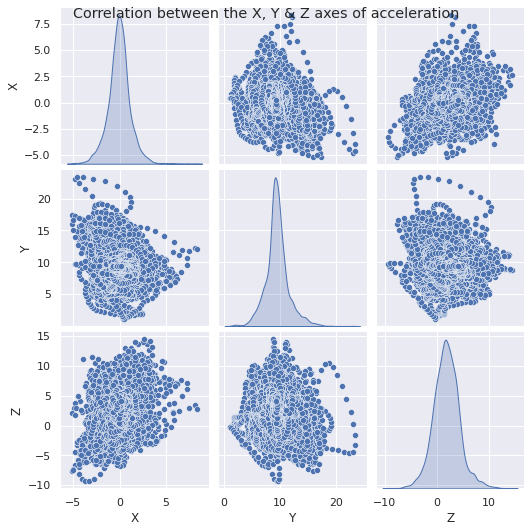

In [ ]:
sns.pairplot(df[['X', 'Y', 'Z']], diag_kind='kde').fig.suptitle('Correlation between the X, Y & Z axes of acceleration')

In [ ]:
s = df['X']
lag_x = pd.concat([s, s.shift(-1), s.shift(-2), s.shift(-3), s.shift(-4), s.shift(-5), s.shift(-10), s.shift(-20)], axis=1).dropna()
lag_x.columns = ['x', 'x_lag_1', 'x_lag_2', 'x_lag_3', 'x_lag_4', 'x_lag_5', 'x_lag_10', 'x_lag_20']

s = df['Z']
lag_z = pd.concat([s, s.shift(-1), s.shift(-2), s.shift(-3), s.shift(-4), s.shift(-5), s.shift(-10), s.shift(-20)], axis=1).dropna()
lag_z.columns = ['z', 'z_lag_1', 'z_lag_2', 'z_lag_3', 'z_lag_4', 'z_lag_5', 'z_lag_10', 'z_lag_20']

s = df['Y']
lag_y = pd.concat([s, s.shift(-1), s.shift(-2), s.shift(-3), s.shift(-4), s.shift(-5), s.shift(-10), s.shift(-20)], axis=1).dropna()
lag_y.columns = ['y', 'y_lag_1', 'y_lag_2', 'y_lag_3', 'y_lag_4', 'y_lag_5', 'y_lag_10', 'y_lag_20']

In [ ]:
lag_x['diff_3'] = lag_x['x'] - lag_x['x_lag_3']
lag_x['diff_5'] = lag_x['x'] - lag_x['x_lag_5']
lag_x['diff_10'] = lag_x['x'] - lag_x['x_lag_10']
lag_x['diff_20'] = lag_x['x'] - lag_x['x_lag_20']

lag_z['diff_3'] = lag_z['z'] - lag_z['z_lag_3']
lag_z['diff_5'] = lag_z['z'] - lag_z['z_lag_5']
lag_z['diff_10'] = lag_z['z'] - lag_z['z_lag_10']
lag_z['diff_20'] = lag_z['z'] - lag_z['z_lag_20']

lag_y['diff_3'] = lag_y['y'] - lag_y['y_lag_3']
lag_y['diff_5'] = lag_y['y'] - lag_y['y_lag_5']
lag_y['diff_10'] = lag_y['y'] - lag_y['y_lag_10']
lag_y['diff_20'] = lag_y['y'] - lag_y['y_lag_20']

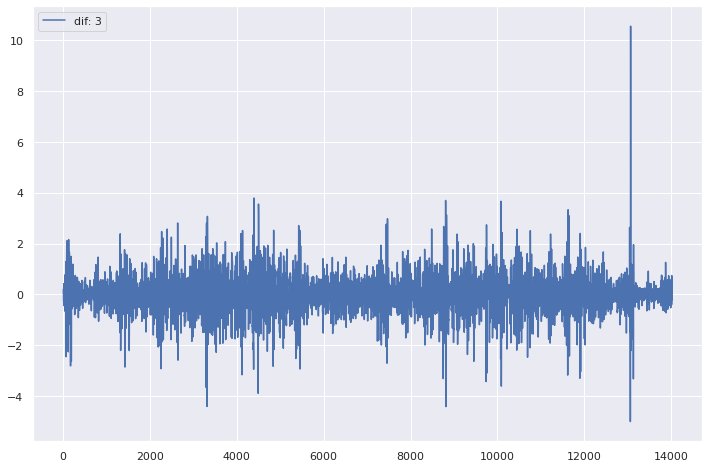

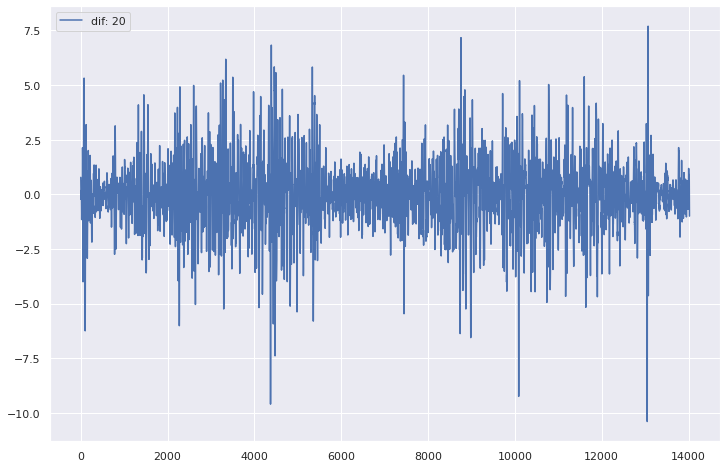

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(lag_x['diff_3'], label='dif: 3')
plt.legend()
plt.show()
plt.figure(figsize=(12,8))
plt.plot(lag_x['diff_20'], label='dif: 20')
plt.legend()
plt.show()

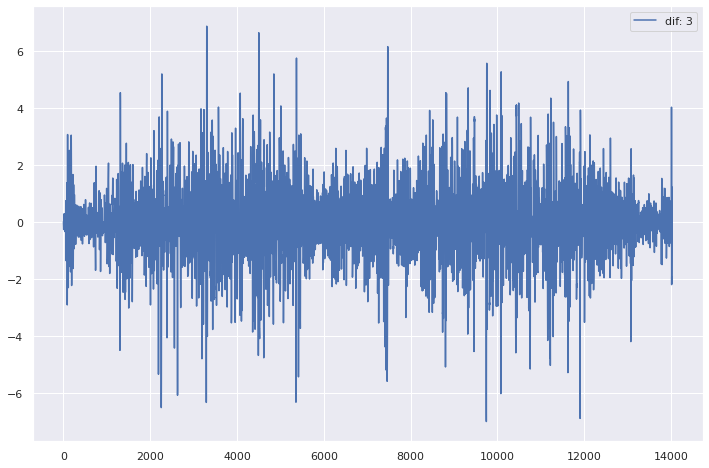

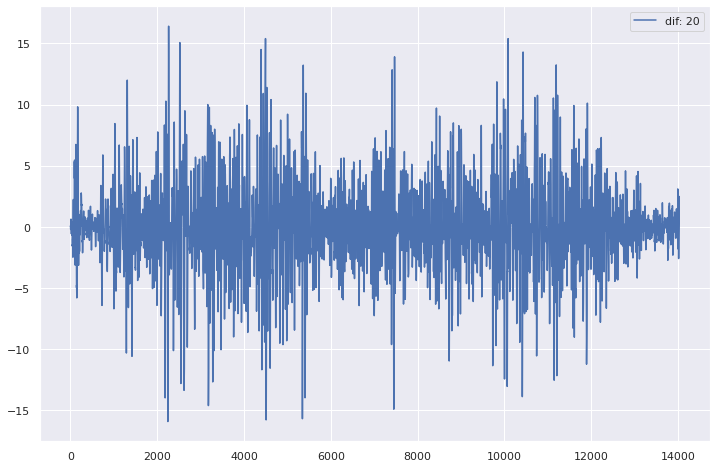

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(lag_z['diff_3'], label='dif: 3')
plt.legend()
plt.show()
plt.figure(figsize=(12,8))
plt.plot(lag_z['diff_20'], label='dif: 20')
plt.legend()
plt.show()

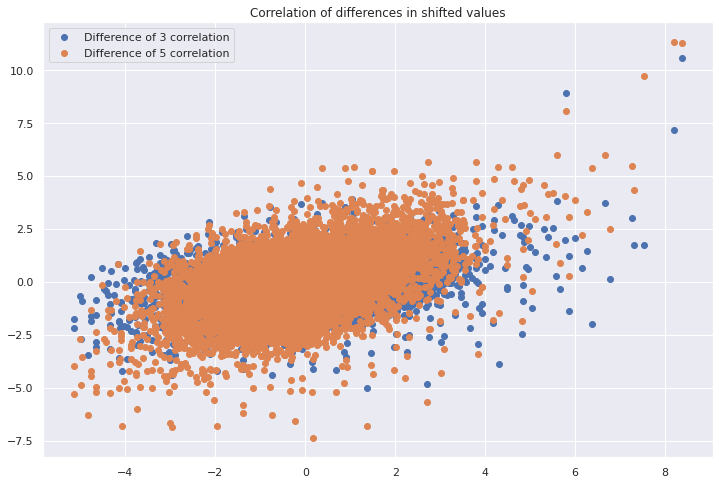

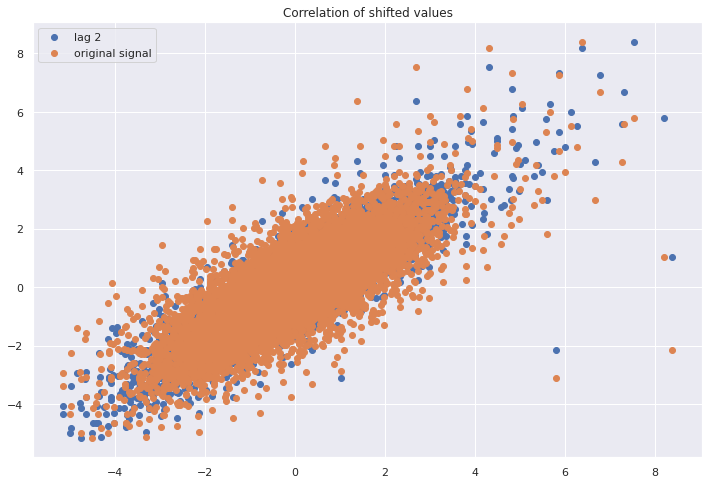

In [ ]:
plt.figure(figsize=(12,8))
plt.scatter(lag_x['x'], lag_x['diff_3'], label='Difference of 3 correlation')
plt.scatter(lag_x['x'], lag_x['diff_5'], label='Difference of 5 correlation')
plt.title('Correlation of differences in shifted values')
plt.legend()
plt.show()

plt.figure(figsize=(12,8))
plt.scatter(lag_x['x'], lag_x['x_lag_2'], label='lag 2')
plt.scatter(lag_x['x'], lag_x['x_lag_3'], label='original signal')
plt.title('Correlation of shifted values')
plt.legend()
plt.show()

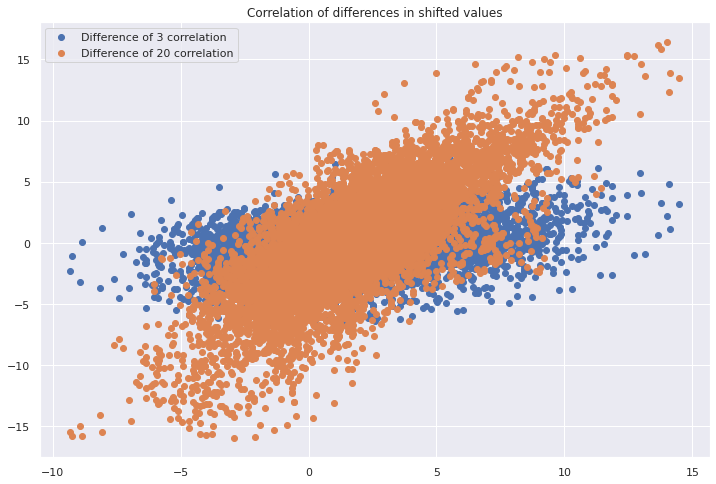

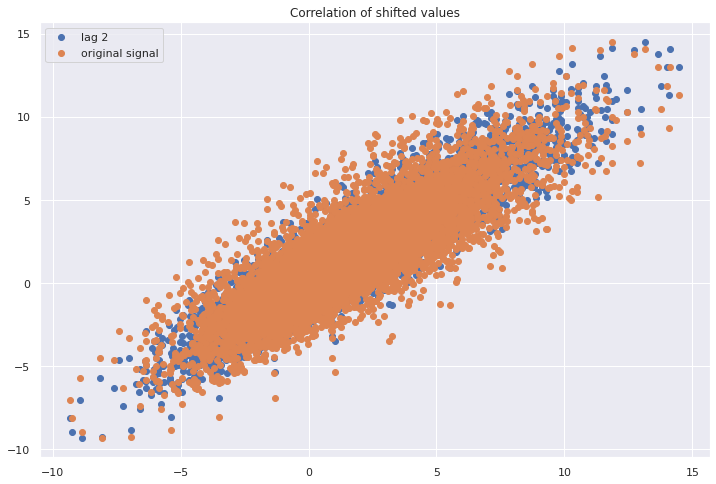

In [ ]:
plt.figure(figsize=(12,8))
plt.scatter(lag_z['z'], lag_z['diff_3'], label='Difference of 3 correlation')
plt.scatter(lag_z['z'], lag_z['diff_20'], label='Difference of 20 correlation')
plt.title('Correlation of differences in shifted values')
plt.legend()
plt.show()

plt.figure(figsize=(12,8))
plt.scatter(lag_z['z'], lag_z['z_lag_2'], label='lag 2')
plt.scatter(lag_z['z'], lag_z['z_lag_3'], label='original signal')
plt.title('Correlation of shifted values')
plt.legend()
plt.show()

In [ ]:
# calculate Pearson's correlation
corr, _ = sp.stats.pearsonr(lag_x['x'], lag_x['x_lag_3'])
corr2, _ = sp.stats.pearsonr(lag_x['x'], lag_x['diff_3'])
corr3, _ = sp.stats.pearsonr(lag_x['x'], lag_x['diff_5'])
corr4, _ = sp.stats.pearsonr(lag_x['x'], lag_x['diff_10'])
corr5, _ = sp.stats.pearsonr(lag_x['diff_3'], lag_x['diff_20'])
print("\n \n==============================================\n")
print(f'Pearsons correlation \n X and lag_x_3: {corr:.3f} \n X and diff_lag_3: {corr2:.3f} \n X and diff_lag_5: {corr3:.3f} \n X and diff_lag_10: {corr4:.3f}')
print(f' diff_lag_3 & diff_lag_10: {corr5:.3f}')
print("\n==============================================\n")


 

Pearsons correlation 
 X and lag_x_3: 0.782 
 X and diff_lag_3: 0.330 
 X and diff_lag_5: 0.506 
 X and diff_lag_10: 0.744
 diff_lag_3 & diff_lag_10: 0.121




In [ ]:
# calculate Pearson's correlation
corr, _ = sp.stats.pearsonr(lag_z['z'], lag_z['z_lag_3'])
corr2, _ = sp.stats.pearsonr(lag_z['z'], lag_z['diff_3'])
corr3, _ = sp.stats.pearsonr(lag_z['z'], lag_z['diff_5'])
corr4, _ = sp.stats.pearsonr(lag_z['z'], lag_z['diff_10'])
corr5, _ = sp.stats.pearsonr(lag_z['diff_3'], lag_z['diff_20'])
print("\n \n==============================================\n")
print(f'Pearsons correlation \n X and lag_x_3: {corr:.3f} \n X and diff_lag_3: {corr2:.3f} \n X and diff_lag_5: {corr3:.3f} \n X and diff_lag_10: {corr4:.3f}')
print(f' diff_lag_3 & diff_lag_10: {corr5:.3f}')
print("\n==============================================\n")


 

Pearsons correlation 
 X and lag_x_3: 0.848 
 X and diff_lag_3: 0.276 
 X and diff_lag_5: 0.433 
 X and diff_lag_10: 0.687
 diff_lag_3 & diff_lag_10: 0.098




The difference 3 and difference 20 has low correlation with the original x-acceleration then the shifted values. Hence, they'll be more useful.

#Labelling values as plain surface and non plain surface



In [ ]:
x_min = df['X'].min()
x_max = df['X'].max()
x_std = df['X'].std()
x_mean = df['X'].mean()

y_min = df['Y'].min()
y_max = df['Y'].max()
y_std = df['Y'].std()
y_mean = df['Y'].mean()

z_min = df['Z'].min()
z_max = df['Z'].max()
z_std = df['Z'].std()
z_mean = df['Z'].mean()

In [ ]:

conditions = [(lag_x['x'] > x_mean + x_std),
              (lag_x['x'] < x_mean + x_std),
              (lag_x['x'] < x_mean - x_std)]
values = [0, 1, 0]

lag_x['Label_x_thres'] = np.select(conditions, values)

lag_x.head()




,x,x_lag_1,x_lag_2,x_lag_3,x_lag_4,x_lag_5,x_lag_10,x_lag_20,diff_3,diff_5,diff_10,diff_20,Label_z_thres,Label_x_thres
1,-1.285553,-1.347809,-1.426804,-1.481873,-1.527374,-1.534546,-1.503418,-2.063675,0.196320,0.248993,0.217865,0.778122,0,1
2,-1.347809,-1.426804,-1.481873,-1.527374,-1.534546,-1.546524,-1.362167,-2.066055,0.179566,0.198715,0.014359,0.718247,0,1
3,-1.426804,-1.481873,-1.527374,-1.534546,-1.546524,-1.582428,-1.309494,-1.874527,0.107742,0.155624,-0.117310,0.447723,0,1
4,-1.481873,-1.527374,-1.534546,-1.546524,-1.582428,-1.596802,-1.338226,-1.750031,0.064651,0.114929,-0.143646,0.268158,0,1
5,-1.527374,-1.534546,-1.546524,-1.582428,-1.596802,-1.577652,-1.422028,-1.615951,0.055054,0.050278,-0.105347,0.088577,0,1


# Transformation of data

In [ ]:
ax = df.iloc[:,1]
ay = df.iloc[:,2]
az = df.iloc[:,3]
amat = np.array([ax, ay, az])

new_df = TransformData(amat)
new_df.head()

,X,Y,Z
0,2.716455e-16,8.528749e-16,9.845626
1,-1.089254e-16,2.147563e-17,9.802036
2,1.086883e-16,-2.264514e-17,9.801411
3,-7.729495e-17,-8.917468e-16,9.879896
4,-7.957480e-17,-8.915462e-16,9.974416


In [ ]:
new_df['EMAx'] = df['X'].ewm(span=10, adjust=False).mean()
new_df['EMAy'] = df['Y'].ewm(span=10, adjust=False).mean()
new_df['EMAz'] = df['Z'].ewm(span=10, adjust=False).mean()
new_df.tail()

,X,Y,Z,EMAx,EMAy,EMAz
14037,4.852044e-17,-2.243071e-18,9.868630,-0.395152,9.212148,2.816165
14038,-3.467564e-18,1.142773e-19,10.024151,-0.402944,9.259860,2.799757
14039,-2.613694e-17,-4.435366e-16,10.097234,-0.386682,9.305863,2.862513
14040,1.558881e-17,1.332176e-15,10.184852,-0.363801,9.330444,2.991342
14041,-2.938791e-17,-8.890200e-16,10.287145,-0.317655,9.343153,3.159870



 -------------- X ---------------------


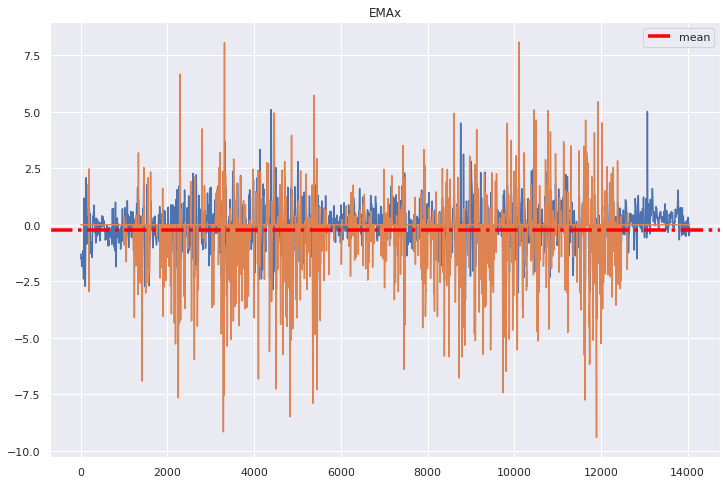

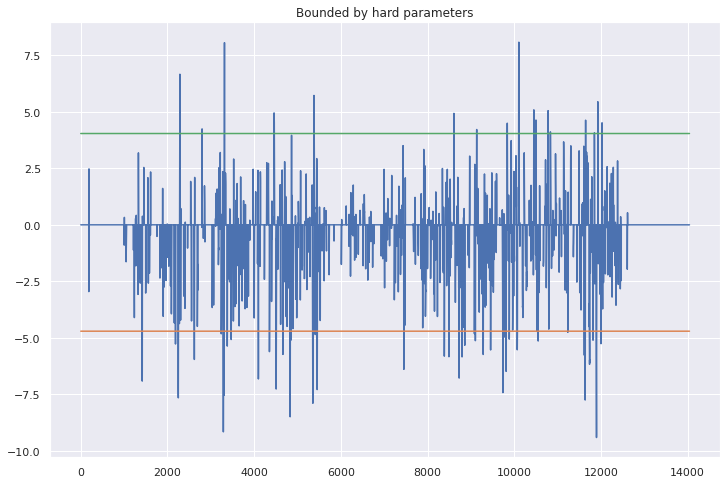

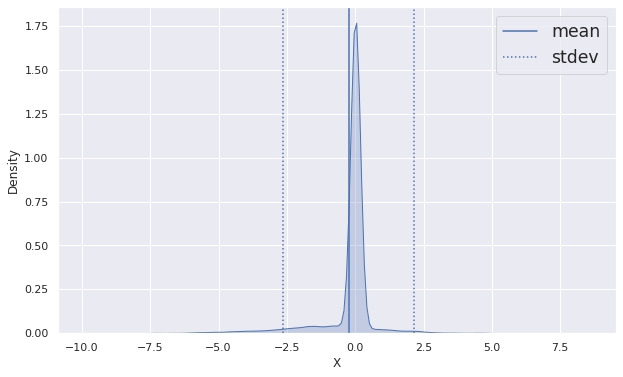

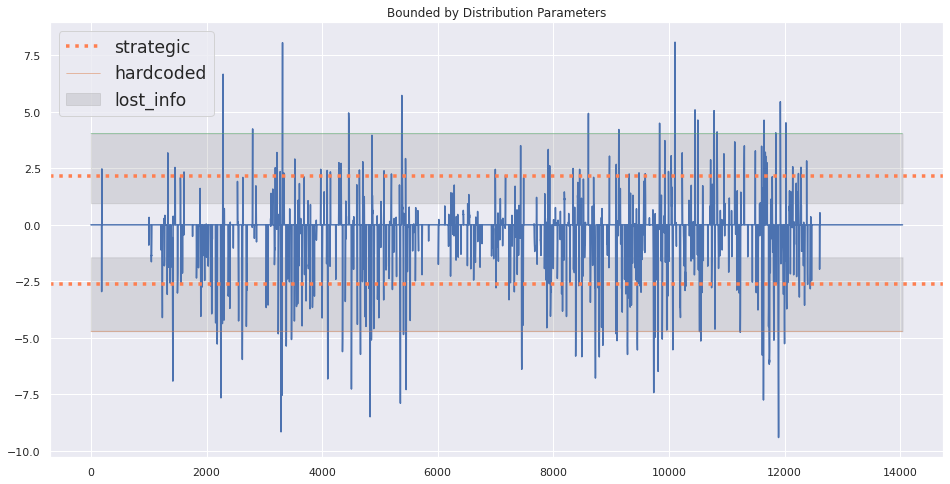


 -------------- END ---------------------

 -------------- Y ---------------------


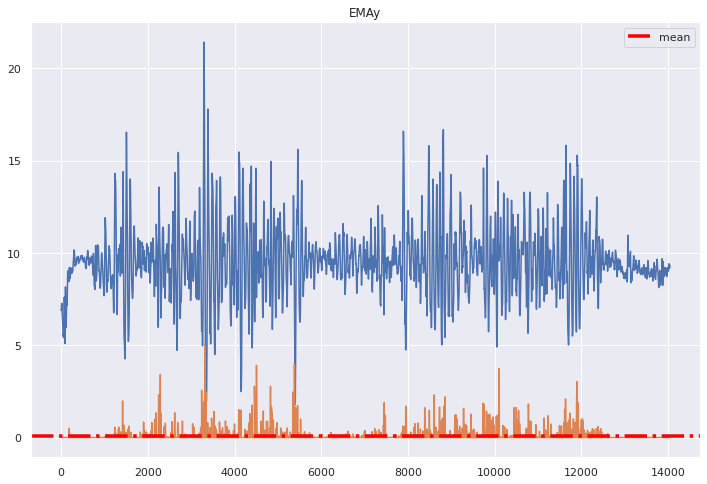

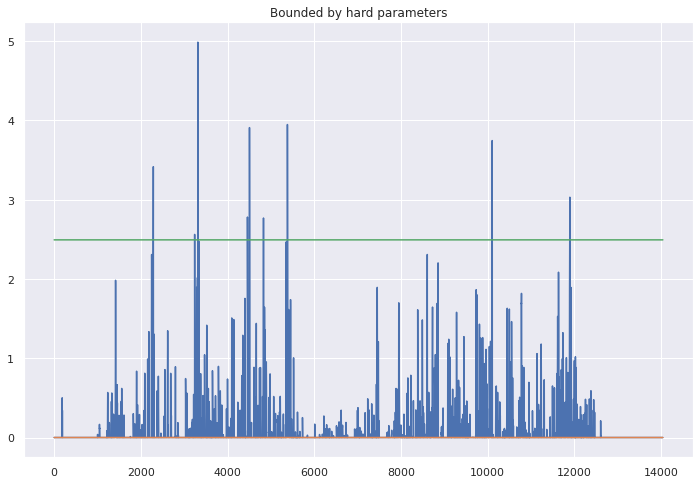

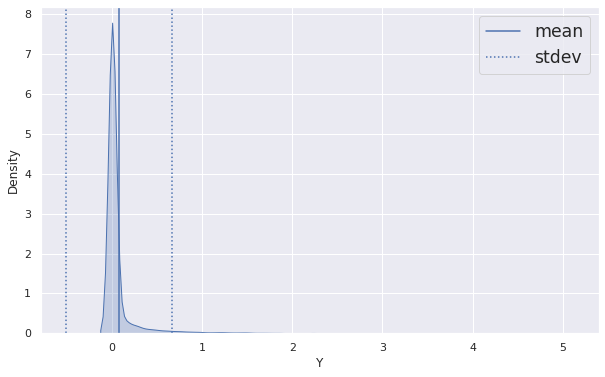

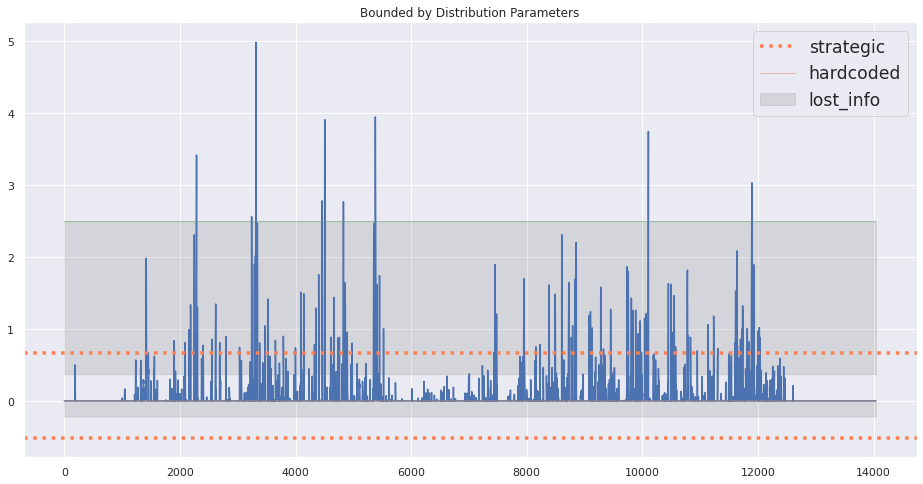


 -------------- END ---------------------

 -------------- Z ---------------------


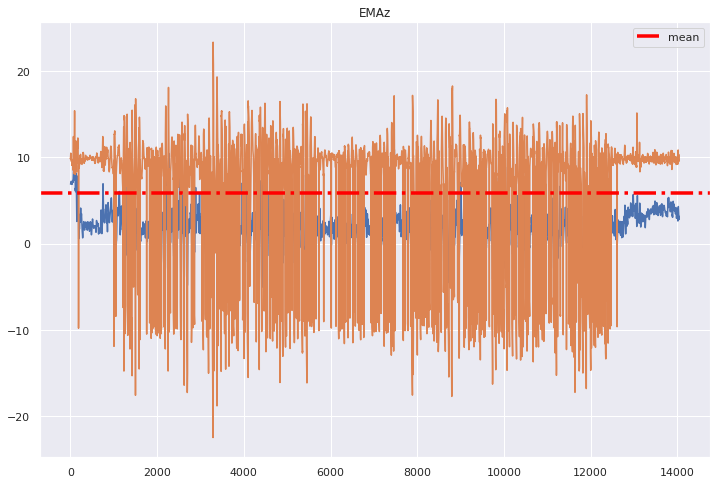

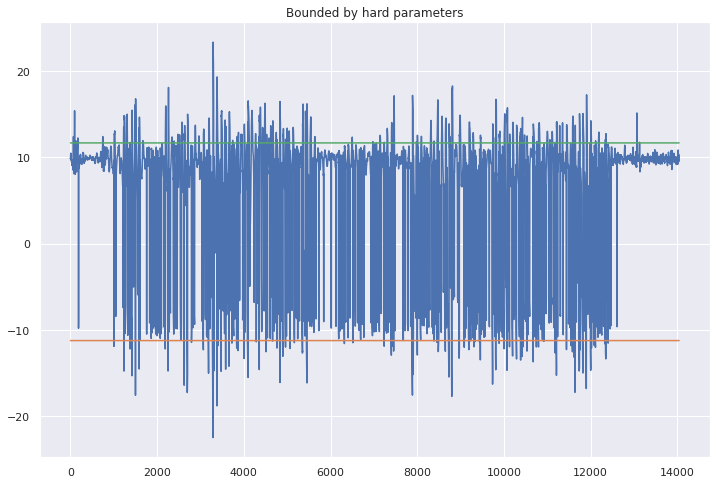

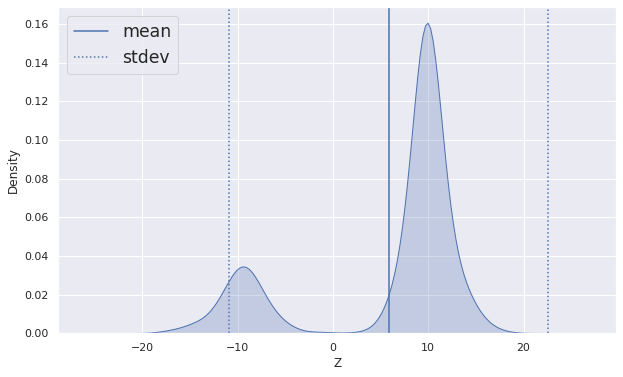

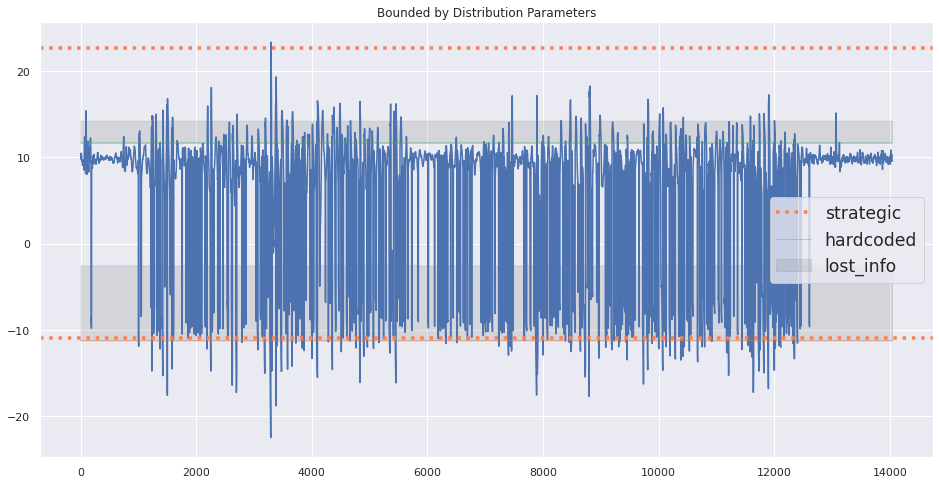


 -------------- END ---------------------


In [ ]:
for cols in ['X', 'Y', 'Z']:
  Analysis_pipeline(new_df, cols)

# Different Thresholding values

Z-THRESHOLD,  Z-DIFFERENCE,  G-ZERO

In [ ]:
#Z-THRES

conditions_z = [(lag_z['z'] > z_mean + z_std),
              ((lag_z['z'] < z_mean + z_std) & (lag_z['z'] > z_mean - z_std)),
              (lag_z['z'] < z_mean - z_std)]

values_z = [1, 0, -1]

lag_z['Label_z_thres'] = np.select(conditions_z, values_z)

lag_z.groupby('Label_z_thres').count()


,z,z_lag_1,z_lag_2,z_lag_3,z_lag_4,z_lag_5,z_lag_10,z_lag_20,diff_3,diff_5,diff_10,diff_20,Label_g_zero
Label_z_thres,,,,,,,,,,,,,
-1,1961,1961,1961,1961,1961,1961,1961,1961,1961,1961,1961,1961,1961
0,10267,10267,10267,10267,10267,10267,10267,10267,10267,10267,10267,10267,10267
1,1794,1794,1794,1794,1794,1794,1794,1794,1794,1794,1794,1794,1794


In [ ]:
#Z-DIFF

conditions_z = [(lag_z['z'] -lag_z['z_lag_1'] > z_mean),
              ((lag_z['z'] -lag_z['z_lag_1']< z_mean + z_std) & (lag_z['z'] -lag_z['z_lag_1'] > z_mean - z_std) ),
              (lag_z['z'] - lag_z['z_lag_1']< z_mean - z_std)]

values_z = [1, 0, -1]

lag_z['Label_z_diff'] = np.select(conditions_z, values_z)

lag_z.groupby('Label_z_diff').count()
# lag_z.Label_z_diff.count()



,z,z_lag_1,z_lag_2,z_lag_3,z_lag_4,z_lag_5,z_lag_10,z_lag_20,diff_3,diff_5,diff_10,diff_20,Label_g_zero,Label_z_thres
Label_z_diff,,,,,,,,,,,,,,
-1,928,928,928,928,928,928,928,928,928,928,928,928,928,928
0,13074,13074,13074,13074,13074,13074,13074,13074,13074,13074,13074,13074,13074,13074
1,20,20,20,20,20,20,20,20,20,20,20,20,20,20


In [ ]:
#G-Zero

conditions_g = [((lag_z['z'] > z_std )& (lag_y['y'] > y_std) & (lag_x['x'] > x_std) | ((lag_z['z'] < -1*z_std )& (lag_y['y'] < -1*y_std) & (lag_x['x'] < -1*x_std))),
              (((lag_z['z'] < z_std )& (lag_y['y'] < y_std) & (lag_x['x'] < x_std))&((lag_z['z'] > -1*z_std )& (lag_y['y'] > -1*y_std) & (lag_x['x'] > -1*x_std))),
              (lag_z['z'] - lag_z['z_lag_1']< z_mean - z_std)]

values_z = [0, 1, -1]

lag_z['Label_g_zero'] = np.select(conditions_g, values_z)

lag_z.groupby('Label_g_zero').count()

,z,z_lag_1,z_lag_2,z_lag_3,z_lag_4,z_lag_5,z_lag_10,z_lag_20,diff_3,diff_5,diff_10,diff_20
Label_g_zero,,,,,,,,,,,,
-1,789,789,789,789,789,789,789,789,789,789,789,789
0,13215,13215,13215,13215,13215,13215,13215,13215,13215,13215,13215,13215
1,18,18,18,18,18,18,18,18,18,18,18,18


In [ ]:
import cvxopt
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.svm import LinearSVC, SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report

**Without combining the different Threshold values and using Z-Threshold**

In [ ]:

feature_cols = ['z', 'diff_3', 'diff_20']
target_col = ['Label_z_thres']

features = lag_z[feature_cols]
target = lag_z[target_col]

X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size=0.3, random_state=42)

1        1
2        1
3        1
4        1
5        1
        ..
14018    1
14019    1
14020    1
14021    1
14022    1
Name: Label_z_thres, Length: 14022, dtype: int64


In [ ]:
# define model
model = LinearDiscriminantAnalysis()
# fit model
model.fit(X_train, Y_train)
# make a prediction
preds = model.predict(X_test)
report = classification_report(Y_test, preds)
print(report)


              precision    recall  f1-score   support

          -1       1.00      0.86      0.92       569
           0       0.94      1.00      0.97      3107
           1       1.00      0.75      0.86       531

    accuracy                           0.95      4207
   macro avg       0.98      0.87      0.91      4207
weighted avg       0.95      0.95      0.95      4207



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
svm = SVC()

In [ ]:
svm.fit(X_train, Y_train)
preds = svm.predict(X_test)
report = classification_report(Y_test, preds)
print(report)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

          -1       0.99      0.99      0.99       569
           0       0.99      1.00      1.00      3107
           1       0.99      0.98      0.99       531

    accuracy                           0.99      4207
   macro avg       0.99      0.99      0.99      4207
weighted avg       0.99      0.99      0.99      4207



In [ ]:
from sklearn.tree import DecisionTreeClassifier

dTree = DecisionTreeClassifier(criterion = 'gini',max_depth=3, random_state=1)
dTree.fit(X_train,Y_train)

DecisionTreeClassifier(max_depth=3, random_state=1)

In [ ]:
#importance of features
pd.DataFrame(dTree.feature_importances_,columns=["Imp"],index=X_train.columns)

,Imp
z,1.0
diff_3,0.0
diff_20,0.0


In [ ]:
preds = dTree.predict(X_test)
report = classification_report(Y_test, preds)
print(report)

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       569
           0       1.00      1.00      1.00      3107
           1       1.00      1.00      1.00       531

    accuracy                           1.00      4207
   macro avg       1.00      1.00      1.00      4207
weighted avg       1.00      1.00      1.00      4207



**Without combining the threshold for Z-DIFFERENCE**

In [ ]:
lag_z['Label_z_diff']
feature_cols = ['z', 'diff_3', 'diff_20']
target_col = ['Label_z_diff']

features = lag_z[feature_cols]
target = lag_z[target_col]

X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size=0.3, random_state=42)


In [ ]:
# define model
model = LinearDiscriminantAnalysis()
# fit model
model.fit(X_train, Y_train)
# make a prediction
preds = model.predict(X_test)
report = classification_report(Y_test, preds)
print(report)

              precision    recall  f1-score   support

          -1       0.95      0.57      0.71       277
           0       0.97      1.00      0.98      3925
           1       0.56      1.00      0.71         5

    accuracy                           0.97      4207
   macro avg       0.83      0.85      0.80      4207
weighted avg       0.97      0.97      0.97      4207



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
svm=SVC()
svm.fit(X_train, Y_train)
preds = svm.predict(X_test)
report = classification_report(Y_test, preds)
print(report)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

          -1       0.87      0.78      0.83       277
           0       0.98      0.99      0.99      3925
           1       0.00      0.00      0.00         5

    accuracy                           0.98      4207
   macro avg       0.62      0.59      0.60      4207
weighted avg       0.98      0.98      0.98      4207



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:


dTree = DecisionTreeClassifier(criterion = 'gini',max_depth=3, random_state=1)
dTree.fit(X_train,Y_train)
preds = dTree.predict(X_test)
report = classification_report(Y_test, preds)
print(report)

              precision    recall  f1-score   support

          -1       0.83      0.84      0.83       277
           0       0.99      0.99      0.99      3925
           1       0.60      0.60      0.60         5

    accuracy                           0.98      4207
   macro avg       0.80      0.81      0.81      4207
weighted avg       0.98      0.98      0.98      4207



**Without combining the threshold values and using g-zero threshold**

In [ ]:
lag_z['Label_g_zero']
feature_cols = ['z', 'diff_3', 'diff_20']
target_col = ['Label_g_zero']

features = lag_z[feature_cols]
target = lag_z[target_col]

X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size=0.3, random_state=42)

In [ ]:
# define model
model = LinearDiscriminantAnalysis()
# fit model
model.fit(X_train, Y_train)
# make a prediction
preds = model.predict(X_test)
report = classification_report(Y_test, preds)
print(report)

              precision    recall  f1-score   support

          -1       0.79      0.47      0.59       244
           0       0.97      0.99      0.98      3958
           1       0.00      0.00      0.00         5

    accuracy                           0.96      4207
   macro avg       0.59      0.49      0.52      4207
weighted avg       0.96      0.96      0.96      4207



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and

In [ ]:
svm=SVC()
svm.fit(X_train, Y_train)
preds = svm.predict(X_test)
report = classification_report(Y_test, preds)
print(report)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

          -1       0.81      0.68      0.74       244
           0       0.98      0.99      0.98      3958
           1       0.00      0.00      0.00         5

    accuracy                           0.97      4207
   macro avg       0.60      0.56      0.58      4207
weighted avg       0.97      0.97      0.97      4207



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:

dTree = DecisionTreeClassifier(criterion = 'gini',max_depth=3, random_state=1)
dTree.fit(X_train,Y_train)
preds = dTree.predict(X_test)
report = classification_report(Y_test, preds)
print(report)

              precision    recall  f1-score   support

          -1       0.73      0.77      0.75       244
           0       0.98      0.98      0.98      3958
           1       0.00      0.00      0.00         5

    accuracy                           0.97      4207
   macro avg       0.57      0.58      0.58      4207
weighted avg       0.97      0.97      0.97      4207



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
